In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Load Dataset


In [99]:
df = pd.read_csv('C:\\Users\\LEGION\\Downloads\\hackathon_ribo\\hackathon\\notebooks\\Data_Handeling\\transformed_data\\final_data.csv')

In [100]:
df

,price_total,room_type,is_shared_room,is_private_room,max_guests,is_superhost,is_multi_listing,is_business_listing,cleanliness_score,guest_satisfaction_score,...,Crime_Index,Safety_Index,Monthly_Average_Net_salary,Meal_at_Inexpensive_Restaurant,Taxi_price_per_Km,Monthly_Basic_Utilities,Monthly_Rent_One_Bedroom_CC,Monthly_Rent_One_Bedroom_OCC,Monthly_Rent_Three_Bedroom_CC,Monthly_Rent_Three_Bedroom_OCC
0,194.033698,Private room,0,1,2.0,0,1,0,10.0,93.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
1,344.245776,Private room,0,1,4.0,0,0,0,8.0,85.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
2,264.101422,Private room,0,1,2.0,0,0,1,9.0,87.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
3,433.529398,Private room,0,1,4.0,0,0,1,9.0,90.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
4,485.552926,Private room,0,1,2.0,1,0,0,10.0,98.0,...,25.7,74.3,4502.1,20.50,3.0,262.0,2178.68,1701.26,3725.50,2785.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51702,715.938574,Entire home/apt,0,0,6.0,0,0,1,10.0,100.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78
51703,304.793960,Entire home/apt,0,0,2.0,0,0,0,8.0,86.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78
51704,637.168969,Entire home/apt,0,0,2.0,0,0,0,10.0,93.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78
51705,301.054157,Private room,0,1,2.0,0,0,0,10.0,87.0,...,28.4,71.6,3135.2,18.25,1.9,291.2,1082.80,763.71,2063.57,1302.78


# 2. Select Features & Target


In [101]:
features = [
    'room_type', 'city', 'max_guests', 'num_bedrooms', 
    'distance_city_center', 'cleanliness_score', 
    'Monthly_Average_Net_salary', 'Meal_at_Inexpensive_Restaurant',
    'Taxi_price_per_Km', 'Monthly_Basic_Utilities'
]
X = df[features]
# Log transform the target to handle skewness and prevent negative predictions
y = np.log1p(df['price_total'])

# Handling Outliers


In [96]:
Q1 = df['price_total'].quantile(0.25)
Q3 = df['price_total'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [104]:
df_cleaned = df[(df['price_total'] >= lower_bound) & (df['price_total'] <= upper_bound)]
print(f"Removed {len(df) - len(df_cleaned)} outliers.")

Removed 3662 outliers.


# Preprocessing


In [105]:
categorical_features = ['room_type', 'city']
numerical_features = [
    'max_guests', 'num_bedrooms', 'distance_city_center', 
    'cleanliness_score', 'Monthly_Average_Net_salary', 
    'Meal_at_Inexpensive_Restaurant', 'Taxi_price_per_Km', 'Monthly_Basic_Utilities'
]

In [106]:
X= df_cleaned[categorical_features + numerical_features]
y = np.log1p(df_cleaned['price_total'])

In [107]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [108]:
def evaluate_model(model, name):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    
    # Predictions
    preds_log = pipeline.predict(X_test)
    preds_actual = np.expm1(preds_log)
    y_test_actual = np.expm1(y_test)
    
    # Metrics
    r2 = r2_score(y_test, preds_log)
    mae = mean_absolute_error(y_test_actual, preds_actual)
    rmse = np.sqrt(mean_squared_error(y_test_actual, preds_actual))
    
    print(f"\n--- {name} Results ---")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: ${mae:.2f}")
    print(f"RMSE: ${rmse:.2f}")
    return pipeline

# Run Linear Regression
lr_pipeline = evaluate_model(LinearRegression(), "Linear Regression")

# Run XGBoost (Higher performance for non-linear data)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_pipeline = evaluate_model(xgb_model, "XGBoost")

# 6. Save the best model (usually XGBoost)
joblib.dump(xgb_pipeline, 'listing_model.pkl')
print("\nBest model saved as listing_model.pkl")


--- Linear Regression Results ---
R² Score: 0.5891
MAE: $53.94
RMSE: $74.68

--- XGBoost Results ---
R² Score: 0.6686
MAE: $47.95
RMSE: $67.51

Best model saved as listing_model.pkl


# Model pipelining


In [89]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train & Test


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:
joblib.dump(model_pipeline, 'listing_model.pkl')

['listing_model.pkl']

Model Accuracy (R² Score): 0.6339
Mean Absolute Error (MAE): $84.20
Root Mean Squared Error (RMSE): $304.42


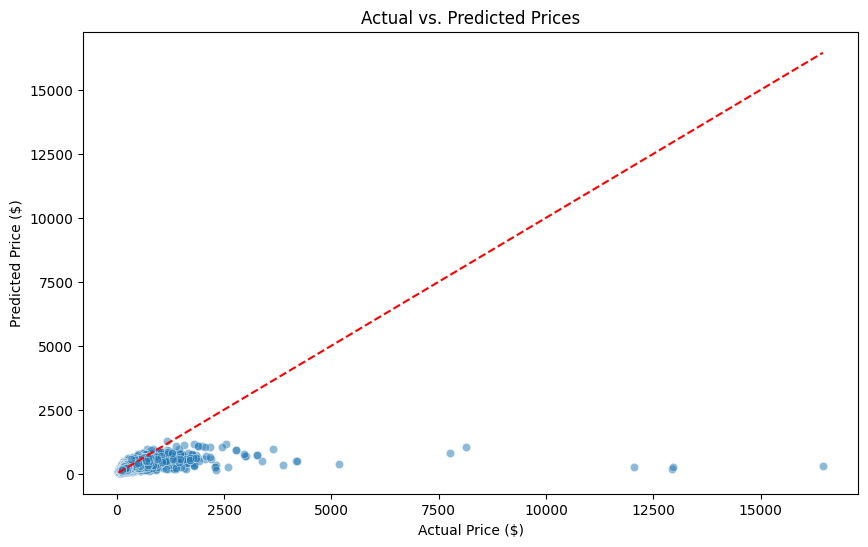

In [93]:
from sklearn.metrics import mean_squared_error


y_pred_log = model_pipeline.predict(X_test)

# 2. Convert log-predictions back to actual currency (USD/EUR)
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 3. Calculate Scores
r2 = r2_score(y_test, y_pred_log)  # R2 is usually calculated on the log scale for transformed models
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Model Accuracy (R² Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# 4. Visual Comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()

In [94]:
from xgboost import XGBRegressor

# Replace LinearRegression with XGBoost in your existing pipeline logic
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6))
])

# Re-train and check the new scores
model_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Model Accuracy (R² Score): 0.6996
Mean Absolute Error (MAE): $76.37
Root Mean Squared Error (RMSE): $292.43


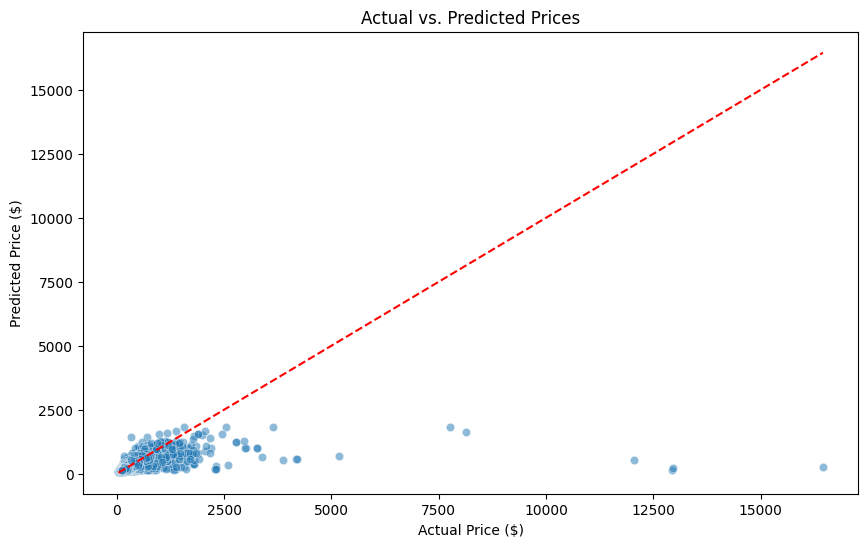

In [95]:
from sklearn.metrics import mean_squared_error


y_pred_log = model_pipeline.predict(X_test)

# 2. Convert log-predictions back to actual currency (USD/EUR)
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# 3. Calculate Scores
r2 = r2_score(y_test, y_pred_log)  # R2 is usually calculated on the log scale for transformed models
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Model Accuracy (R² Score): {r2:.4f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# 4. Visual Comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--r')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()